# Projekt - Znadowanie Sumy i Przecięcia Dwóch Wielokątów

#### Przygotował Jan Chyb

### Konfiguracja Rysowania - Kod z Labolatorium 4

In [2]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [3]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_rect = Button(ax_add_rect, 'Dodaj figury')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

## Implementacja Algorytmu Greinera - Hormanna

In [4]:
EPS = 1e-14

# struktura tworząca listę wierzchoków
class Vertex:
    def __init__(self, point, previous):
        self.point = point
        if(previous is not None): previous.next = self
        self.previous = previous
        self.intersection = False
        self.neighbour = None # odpowiednik 
        self.inside = None 
        self.list = [] # zbiór punktów przecięć pomiedzy vertex, a vertex.next
        self.alpha = 0 # określa kolejność do sortowania przecięć na odcinku
        self.processed = False
    
    def findAlpha(self, p):
        pNext = self.point
        pPrev = self.previous.point
        u1 = sqrt((pNext[0]-p[0])*(pNext[0]-p[0]) + (pNext[1]-p[1])*(pNext[1]-p[1])) 
        u2 = sqrt((pNext[0]-pPrev[0])*(pNext[0]-pPrev[0]) + (pNext[1]-pPrev[1])*(pNext[1]-pPrev[1]))
        if(u2==0): print("probu2")
        return u1/u2
        
# klucz do sortowania punktów przecięć znalezionych na danym odcinku (między vertex, a vertex.next)
def vertexKey(vertex):
    return -vertex.alpha

# zamiana listy odcinków na dwukierunkową listę wierzchołków
def convert(lines):
    v = Vertex(lines[0][0], None)
    u = Vertex(lines[0][1], v)
    i=1;
    while (v.point != lines[i][1]):
        u = Vertex(lines[i][1], u)
        i += 1
    v.previous = u
    u.next = v
    return v

def det(A,B,C):
    return (A[0]*B[1]+A[1]*C[0]+B[0]*C[1])-(B[1]*C[0]+C[1]*A[0]+A[1]*B[0])

def rayIntersect(point, line):
    if(line[0][0] < line[1][0]):
        return point[0] > line[0][0] and point[0] < line[1][0] and det(line[0],line[1],point) > EPS
    else:
        return point[0] > line[1][0] and point[0] < line[0][0] and det(line[1],line[0],point) > EPS
    
# sprawdza czy punkt jest wewnątrz figury zadanej odcinkami zasadą even-odd 
def isInside(point, lines):
    intersections = 0
    for l in lines:
        if(rayIntersect(point,l)): 
            intersections += 1
    return intersections % 2 == 1

# znajduje punkt przecięcia
def getIntersectPoint(a,b):
    A1 = -(a[1][1]-a[0][1])
    B1 = (a[1][0]-a[0][0])
    C1 = a[0][1]*(a[1][0]-a[0][0]) - (a[1][1]-a[0][1])*(a[0][0])
    A2 = -(b[1][1]-b[0][1])
    B2 = (b[1][0]-b[0][0])
    C2 = b[0][1]*(b[1][0]-b[0][0]) - (b[1][1]-b[0][1])*(b[0][0])
    
    W = (A1 * B2 - A2 * B1)
    Wx = (C1 * B2 - C2 * B1)
    Wy = (A1 * C2 - A2 * C1)
    return (Wx/W,Wy/W)

# sprawdza, czy dwia odcinki się przecinają
def intersect(a,b):
    d1=det(a[0],a[1],b[0])
    d2=det(a[0],a[1],b[1])
    d3=det(b[0],b[1],a[0])
    d4=det(b[0],b[1],a[1])
    flag=False
    if((d1>EPS and d2<-EPS) or (d1<-EPS and d2>EPS)): flag = True
    if(flag and((d3<-EPS and d4>EPS) or (d4<-EPS and d3>EPS))): return True
    
# funkcja pomocnicza, do sprawdzenia
def checkIntersection(n0,n1):
    if(n0[0][0]>n0[1][0]): l1 = [n0[1],n0[0]]
    else: l1 = [n0[0],n0[1]]
    
    if(n1[0][0]>n1[1][0]): l2 = [n1[1],n1[0]]
    else: l2 = [n1[0],n1[1]]    
        
    if(intersect(l1,l2)):
        return getIntersectPoint(l1,l2)
    else: return None

# wkłada znaleziony wierzchołek do struktury wielokąta  
def insertIntersection(vertexFig1, v):
    if(v != None):
        tNext = vertexFig1.next
        tPrev = vertexFig1
        t = v
        t.previous = tPrev
        tPrev.next = t
        t.next = tNext
        t.next.previous = t
    return t
    
def findAndAddAllIntersections(vertexFig1, vertexFig2):
    beginningFig1 = vertexFig1
    beginningFig2 = vertexFig2
    addedVertices = []
    addedPoints = []
    
    #znajdowanie punktów przecięcia jednej figury z drugą
    flag1=True
    while vertexFig1 != beginningFig1 or flag1:
        flag1 = False
        vertexFig2 = beginningFig2
        flag2 = True
        while vertexFig2 != beginningFig2 or flag2:
            flag2 = False
            p = checkIntersection([vertexFig1.point, vertexFig1.next.point] ,
                              [vertexFig2.point, vertexFig2.next.point])
            if(p != None):
                u = Vertex(p,None)
                v = Vertex(p,None)
                u.neighbour = v
                u.intersection = True
                v.neighbour = u
                v.intersection = True
                vertexFig1.list.append(u)
                vertexFig2.list.append(v)
                u.alpha = vertexFig1.next.findAlpha(p)
                v.alpha = vertexFig2.next.findAlpha(p)
                addedVertices.append(u)
                addedPoints.append(p)
            vertexFig2 = vertexFig2.next
        
        vertexFig1 = vertexFig1.next
    
    # wstawianie znalezionych punktów do pierwszej listy wierzchołków
    flag = True
    while vertexFig1 != beginningFig1 or flag:
        flag = False
        vertexList = vertexFig1.list
        if(len(vertexList) != 0):
            vertexList.sort(key = vertexKey)
            for v in vertexList:
                insertIntersection(vertexFig1, v)
                vertexFig1 = vertexFig1.next
        vertexFig1 = vertexFig1.next
    
    # wstawianie znalezionych punktów do drugiej listy wierzchołków
    flag = True
    while vertexFig2 != beginningFig2 or flag:
        flag = False
        vertexList = vertexFig2.list
        if(len(vertexList) != 0):
            vertexList.sort(key = vertexKey)
            for v in vertexList:
                insertIntersection(vertexFig2, v)
                vertexFig2 = vertexFig2.next
        vertexFig2 = vertexFig2.next
    return addedVertices, addedPoints

# oznaczanie kolejnych wierzchołków listy, czy są wewnątrz danej figury, czy nie
def evenOddRule(vertexFig):
    pointsInside = []
    pointsOutside = []
    
    beginningFig = vertexFig
    flag = True
    while vertexFig != beginningFig or flag:
        
        if(vertexFig.inside): pointsInside.append(vertexFig.point)
        else: pointsOutside.append(vertexFig.point)
            
        flag = False
        vertexFig.next.inside = vertexFig.inside
        if vertexFig.next.intersection:
            vertexFig.next.inside = not vertexFig.inside
        vertexFig = vertexFig.next  
    return pointsInside, pointsOutside

def greinerHormann(figLines1, figLines2, operation, toDraw):
    scenes = []
    
    if(operation == '&'): insideValue = True
    else: insideValue = False
    
    vertexFig1 = convert(figLines1)
    vertexFig2 = convert(figLines2)
    
    beginningFig1 = vertexFig1
    flag=True
    while vertexFig1 != beginningFig1 or flag:
        flag = False
        vertexFig1 = vertexFig1.next  
    
    # część 1. algorytmu
    addedVertices, addedPoints = findAndAddAllIntersections(vertexFig1, vertexFig2)
    
    if toDraw:
        scenes.append(Scene([PointsCollection(addedPoints, color ='red')],
                            [LinesCollection(figLines1, color = 'green'),LinesCollection(figLines2)]))
        
    # część 2. algorytmu
    vertexFig1.inside = isInside(vertexFig1.point, figLines2)
    vertexFig2.inside = isInside(vertexFig2.point, figLines1)
    
    # ewaluacja przypadku, gdy figury nie mają punktów wspólnych
    if(len(addedPoints) == 0):
           
        if vertexFig1.inside:
            if insideValue: figLines1, figLines2 = figLines2, figLines1
            scenes.append(Scene([],[LinesCollection(fig1Lines),LinesCollection(fig2Lines), 
                            LinesCollection(figlines2,color = 'red')]))
            return figLines2, scenes
        
        elif vertexFig2.inside:
            if insideValue: figLines1, figLines2 = figLines2, figLines1
            scenes.append(Scene([],[LinesCollection(fig1Lines),LinesCollection(fig2Lines), 
                            LinesCollection(figLines1,color = 'red')]))
            return figLines1, scenes
        else:
            if insideValue:
                scenes.append(Scene([],[LinesCollection(fig1Lines),LinesCollection(fig2Lines)]))
                return [], scenes
            else:
                scenes.append(Scene([],[LinesCollection(fig1Lines),LinesCollection(fig2Lines), 
                            LinesCollection(figLines1,color = 'red'),LinesCollection(figLines2,color = 'red')]))
                return [figLines1, figLines2], scenes
    
    # zasada even-odd dla figury 1
    pointsInside1, pointsOutside1 = evenOddRule(vertexFig1)  
    
    # zasada even-odd dla figury 2
    pointsInside2, pointsOutside2 = evenOddRule(vertexFig2)
    
    # rysowanie drugiej części 2. algorytmu
    if toDraw:
        scenes.append(Scene([PointsCollection(pointsInside1, color ='red'),PointsCollection(pointsOutside1, color ='blue', 
                                                                                            marker = '>')],
                            [LinesCollection(figLines1, color = 'green'),LinesCollection(figLines2)]))
        scenes.append(Scene([PointsCollection(pointsInside2, color ='red'),PointsCollection(pointsOutside2, color ='blue',
                                                                                            marker = '>')],
                            [LinesCollection(figLines1, color = 'green'),LinesCollection(figLines2)]))
    
    
    # część 3. algorytmu
    polygonLines = []
    foundPolygons = []
    for v in addedVertices:
        polygon = []
        vertexFig = v
        if vertexFig.processed:
            continue
        vertexFig.processed = True
        while True:
            while vertexFig.inside == insideValue:
                
                if toDraw:
                    polygonLines.append([vertexFig.point,vertexFig.next.point])
                    scenes.append(Scene([PointsCollection(addedPoints, color ='red')],
                            [LinesCollection(figLines1),LinesCollection(figLines2),
                             LinesCollection(polygonLines.copy(),color = 'red')]))
                    
                polygon.append([vertexFig.point,vertexFig.next.point])
                
                vertexFig = vertexFig.next
                if vertexFig.intersection:
                    vertexFig.processed = True
                    vertexFig = vertexFig.neighbour
                    vertexFig.processed = True
                    break;
            else: 
                while True:
                    
                    if toDraw: 
                        polygonLines.append([vertexFig.point,vertexFig.previous.point])
                        scenes.append(Scene([PointsCollection(addedPoints, color ='red')],
                                [LinesCollection(figLines1),LinesCollection(figLines2),
                                 LinesCollection(polygonLines.copy(),color = 'red')]))
                    
                    polygon.append([vertexFig.point,vertexFig.previous.point])
                    
                    vertexFig = vertexFig.previous
                    if vertexFig.intersection:
                        vertexFig.processed = True
                        vertexFig = vertexFig.neighbour
                        vertexFig.processed = True
                        break;
            if polygon[0][0] == polygon[-1][1]:
                break
                
        foundPolygons.append(polygon)
        
    # przerobienie listy figur na listę odcinków (potrzebne do rysowania)
    intersectionFigure = [v for p in foundPolygons for v in p]
    scenes.append(Scene([],[LinesCollection(fig1Lines),LinesCollection(fig2Lines), 
                            LinesCollection(intersectionFigure,color = 'red')]))

    return foundPolygons, scenes
    

### Wprowadzanie Danych

<IPython.core.display.Javascript object>


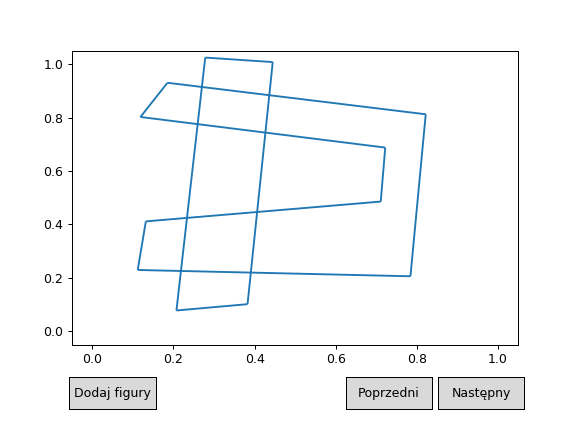

In [5]:
%matplotlib notebook
plot1 = Plot()
plot1.draw()

### Zatwierdzenie Danych

<IPython.core.display.Javascript object>


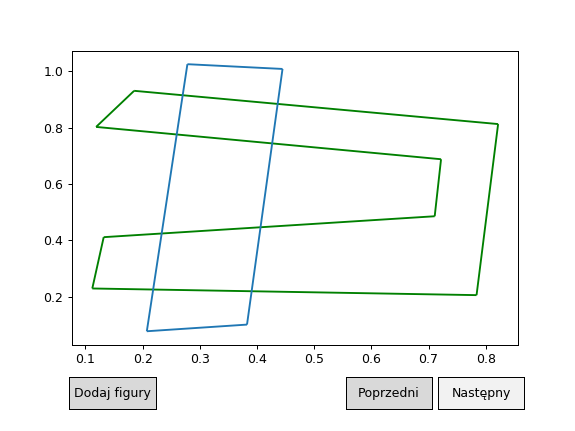

In [6]:
plot2 = Plot([Scene([],[LinesCollection(plot1.get_added_figure()[0].lines, color = "green"),
                         LinesCollection(plot1.get_added_figure()[1].lines)])])
plot2.draw()

### Rozwiązanie - Suma Wielokątów

<IPython.core.display.Javascript object>


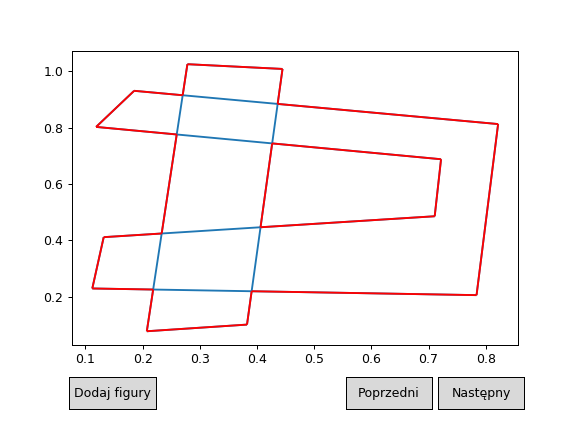

In [7]:
fig1Lines = plot1.get_added_figure()[0].lines
fig2Lines = plot1.get_added_figure()[1].lines
figures, scenes = greinerHormann(fig1Lines, fig2Lines,'|', True)

# aby zobaczyć zwróconą listę wielokątów, można odkomentować
# print(figures)

# rysowanie wyniku
%matplotlib notebook
plot = Plot(scenes)
plot.draw()

### Rozwiązanie - Iloczyn Wielokątów

<IPython.core.display.Javascript object>


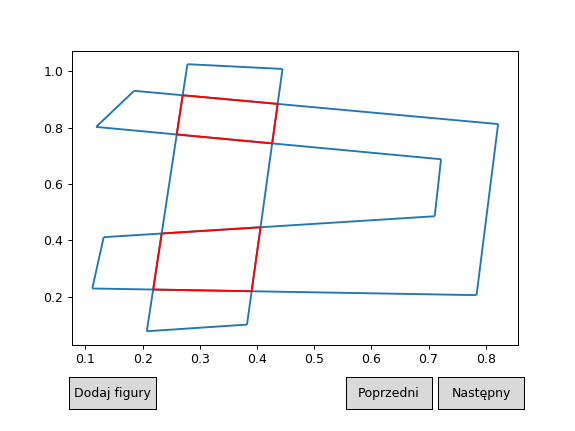

In [8]:
fig1Lines = plot1.get_added_figure()[0].lines
fig2Lines = plot1.get_added_figure()[1].lines
figures, scenes = greinerHormann(fig1Lines, fig2Lines,'&', True)

# aby zobaczyć zwróconą listę wielokątów, można odkomentować
# print(figures)

# rysowanie wyniku
%matplotlib notebook
plot = Plot(scenes)
plot.draw()